In [297]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tqdm 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

# Inspect data

In [298]:
#Load data
df = pd.read_csv("Data/data.csv", sep=",")
df.Date = pd.to_datetime(df.Date)
df.head(3)

,Date,Close,US_infl,CH_infl,US_IR,SARON_close
0,2005-01-03,1.1470,0.210194,-0.5,1.99,0.588191
1,2005-01-04,1.1676,0.210194,-0.5,2.05,0.616042
2,2005-01-05,1.1669,0.210194,-0.5,2.04,0.696835


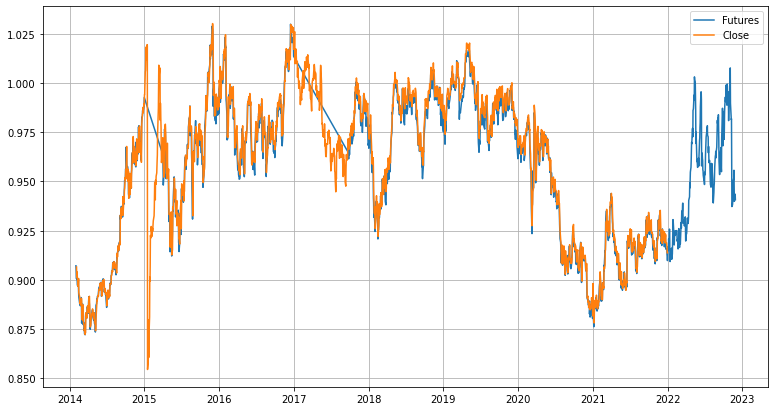

In [299]:
#Check futures 
df_fut = pd.read_csv("Data/futures.csv", sep=",")
df_fut.Date = pd.to_datetime(df_fut.Date)
df_fut = df_fut.sort_values(by="Date")
df_fut = df_fut.rename(columns={'Price': 'Future'})

plt.figure(figsize=(13, 7))
plt.plot(df_fut.Date, 1/df_fut.Future.values, label='Futures')
plt.plot(df[df.Date > df_fut.Date.values[0]].Date, df.Close[df.Date > df_fut.Date.values[0]].values, label='Close')
plt.legend()
plt.grid()
plt.show()

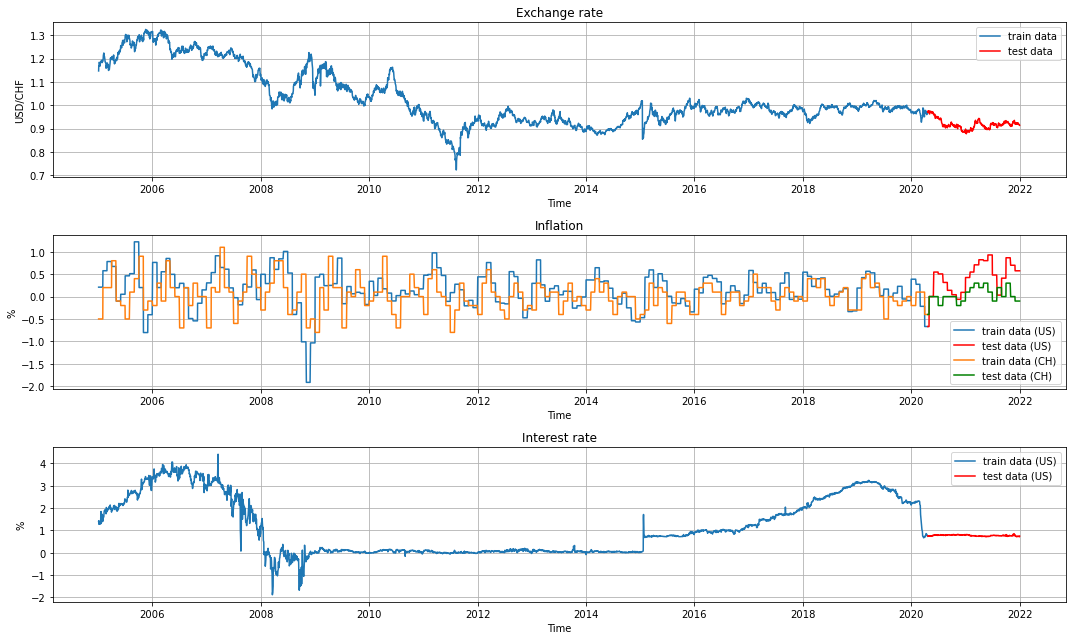

In [302]:
fraction_test = 0.1
#df = df[df.Date >= pd.to_datetime('26-01-2015')]
ds.plot_data(df, fraction_test_ =fraction_test )

# Log-retrun
Log-return : $ln(\frac{p_t}{p_{t-1}})$

From a log-return $R$ the original price $p_t$ : $p_t = p_{t-1}e^R$

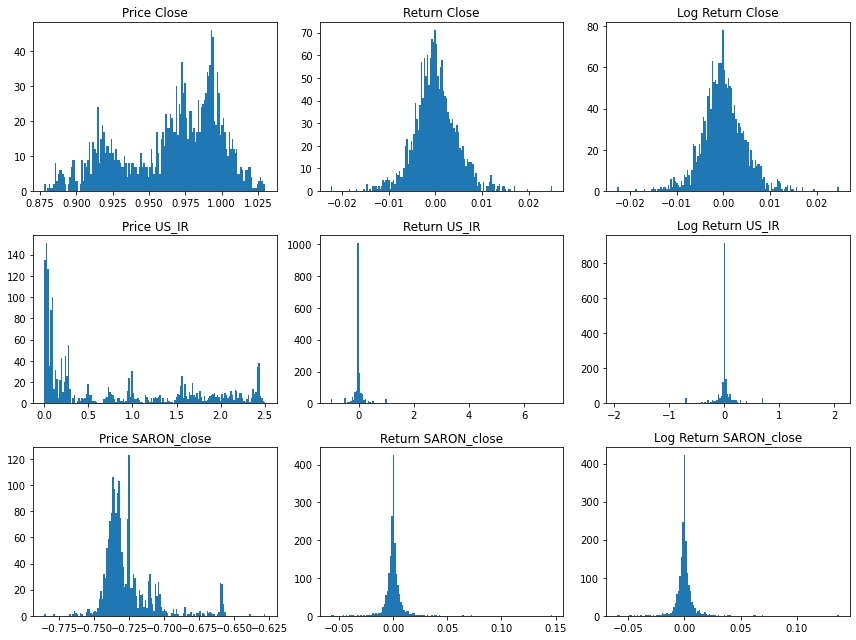

In [6]:
ds.plot_log_ret(df)


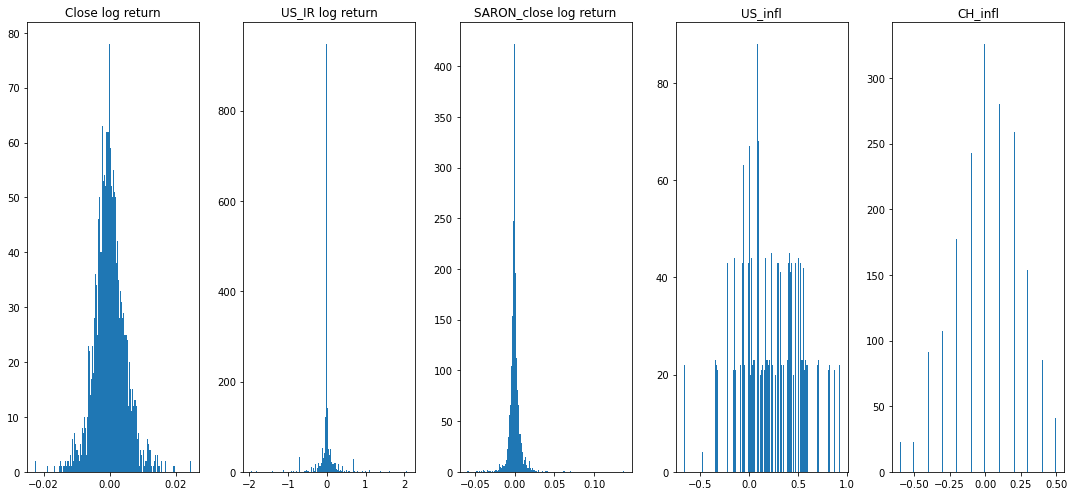

In [162]:
data = [df.Close, df.US_IR, df.SARON_close, df.US_infl, df.CH_infl]

for i in range(3): 
  data[i] = pp.get_log_ret(data[i])

for i in range(3,5): 
  data[i] = data[i].iloc[1:]

fig = plt.figure(figsize=(15, 7))

name  = ['Close log return','US_IR log return', 'SARON_close log return', 'US_infl', 'CH_infl']
for i in range(5):   
    plt.subplot(1,5,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()


# Check auto correlation and partial auto correlation 

Close log return


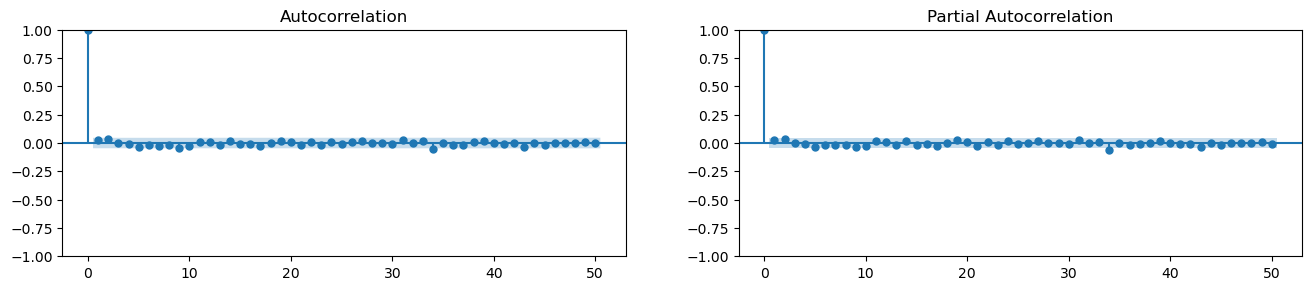

US_IR log return


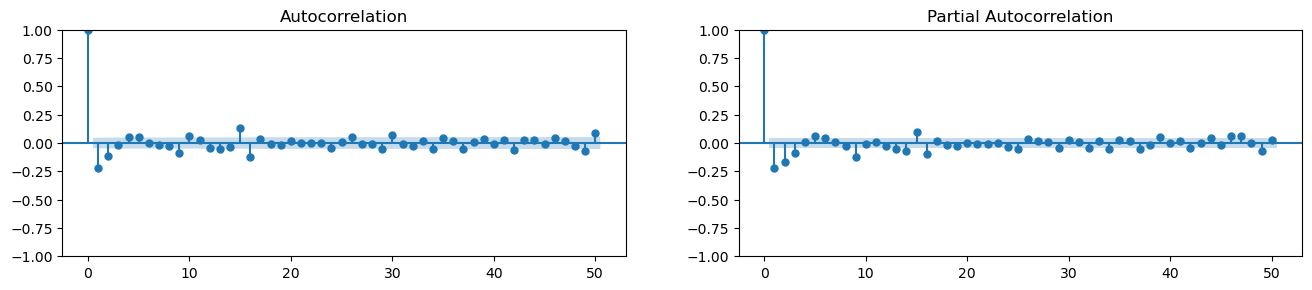

SARON_close log return


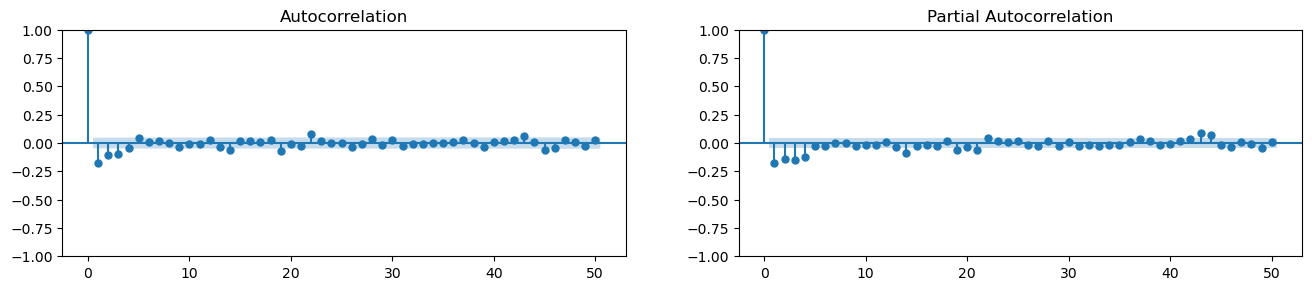

In [163]:
# Draw Plot
for i in range(3):
    print(name[i])
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(data[i].values.tolist(), lags=50, ax=axes[0])
    plot_pacf(data[i].values.tolist(), lags=50, ax=axes[1])
    plt.show()

# PCA analysis

regression score: 0.0026366614382083986


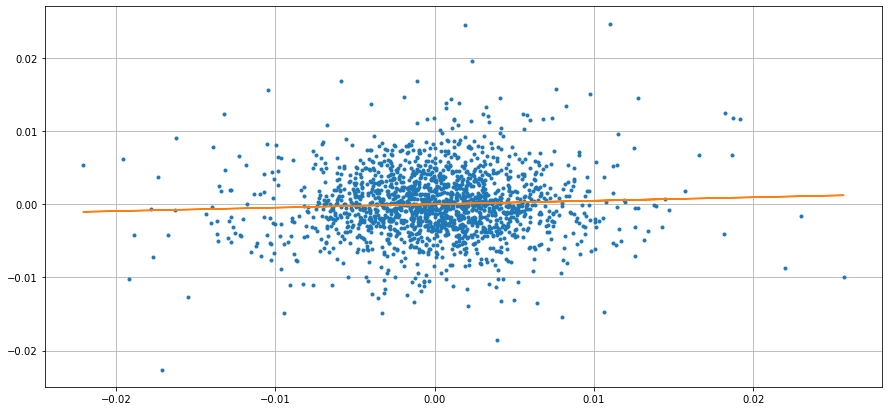

In [164]:
def pca_lookback(data_, lookback_, n_comp_=2):
    train_x,_,_,train_y,_,_,_ = pp.generate_dataset(data_, lookback_=lookback_, norm_=False, fraction_val_=0.01, fraction_test_=0.01, verbose=0)
    #pca
    pca = PCA(n_components=n_comp_)
    pComp= pca.fit_transform(train_x[:,:,0])
    pr_df = pd.DataFrame(data=pComp , columns = [np.arange(n_comp_).astype(str).tolist()])

    #Regression
    X= pr_df.values
    y = train_y[:,0].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    score = reg.score(X, y)
    pred = reg.predict(X)
    return score, pred,  X, y

score, pred, X, y = pca_lookback(data, lookback_=10, n_comp_=1)

print(f"regression score: {score}")

#plot
fig = plt.figure(figsize=(15, 7))
#ax = plt.axes(projection='3d')
plt.plot(X,  y, '.')
plt.plot(X, pred)
plt.grid()
plt.show()

100%|██████████| 45/45 [00:15<00:00,  2.86it/s]


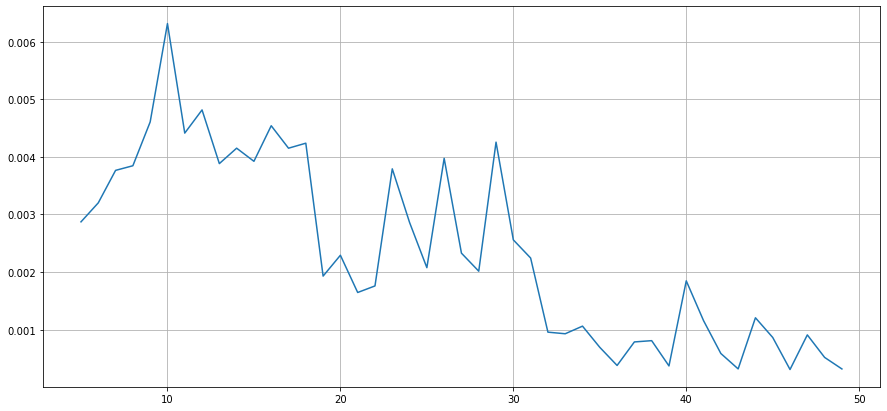

regression score: 0.00631 (0.00264 n_comp_= 1) (lookback = 10)


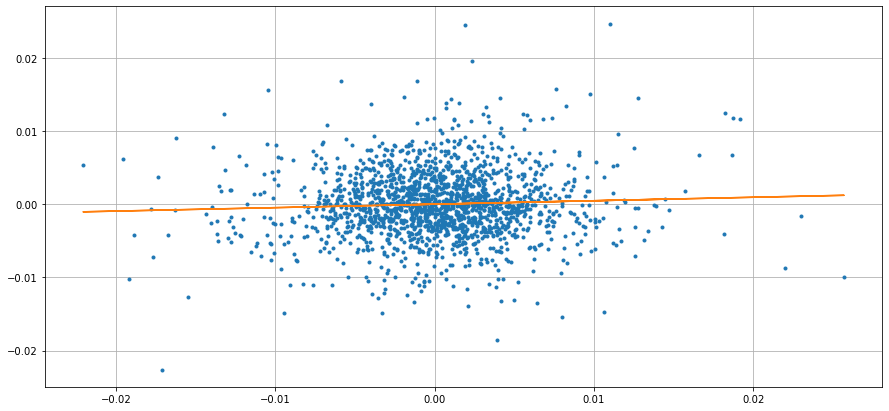

In [165]:
r = range(3, 45)
s, i_top, s_top = pp.best_lookback(data, range_=r, n_comp_=2)

fig = plt.figure(figsize=(15, 7))
plt.plot(r, s)
plt.grid()
plt.show()

score, pred, X, y = pp.pca_lookback(data, lookback_=i_top, n_comp_=1)
print(f"regression score: {s_top:0.05f} ({ score:0.05f} n_comp_= 1) (lookback = {i_top})")

fig = plt.figure(figsize=(15, 7))
plt.plot(X,  y, '.')
plt.plot(X, pred)
plt.grid()
plt.show()


# Generate data

In [183]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=5, norm_=False, fraction_val_=0.3, fraction_test_=fraction_test)

Shape:             
X train     (1136, 5, 5), y train     (1136, 5)            
X train val (488, 5, 5) , y train val (488, 5)             
X test      (180, 5, 5) , y test      (180, 5)


# Baseline

In [294]:
model_dense = ml.Dense(num_layers=5, layer_size=32, input_size=5, output_size=1, dropout=0.05)
model_dense

Dense(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.05, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.05, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=32, out_features=32, bias=True)
    (17): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [295]:
train_loss, val_loss = pl.train(model_dense, train_x[:,:,0], train_y, val_x[:,:,0], val_y, batch_size_= 256, num_epochs_=1000, lr=0.0001, device_='cpu')

 20%|██        | 204/1000 [00:05<00:21, 37.09it/s]

Epoch: 200/1000 MSE = [train :  0.02180539] , [val:  0.00480122]


 40%|████      | 404/1000 [00:11<00:16, 36.15it/s]

Epoch: 400/1000 MSE = [train :  0.00642503] , [val:  0.00087926]


 60%|██████    | 604/1000 [00:16<00:10, 37.60it/s]

Epoch: 600/1000 MSE = [train :  0.00317326] , [val:  0.00034268]


 80%|████████  | 801/1000 [00:24<00:25,  7.78it/s]

Epoch: 800/1000 MSE = [train :  0.00164237] , [val:  0.00015896]


100%|██████████| 1000/1000 [00:33<00:00, 30.01it/s]

Epoch: 1000/1000 MSE = [train :  0.00079386] , [val:  0.00008146]


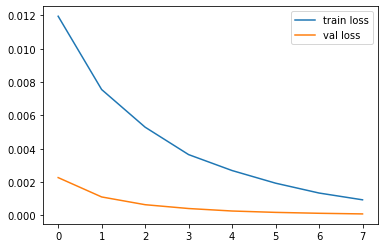

In [303]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 100)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 100)[1:] , label="val loss")
plt.legend()
plt.show()

MSE: 0.004104854572770812%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.154
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.144
Time:                        14:19:47   Log-Likelihood:                 745.43
No. Observations:                 180   AIC:                            -1487.
Df Residuals:                     178   BIC:                            -1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.301e-05    

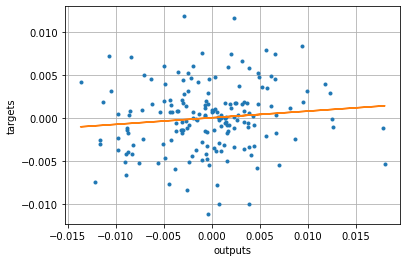

In [308]:
outputs, targets, MSE = pl.evaluate(model_dense, test_x[:,:,0], test_y) 
pl.regression_result(targets,outputs)

accuracy  52.78 %


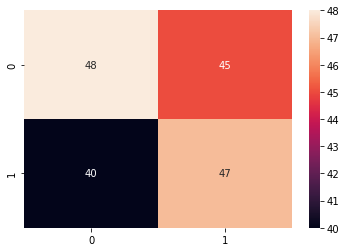

In [309]:
pl.direction_score(outputs, targets)

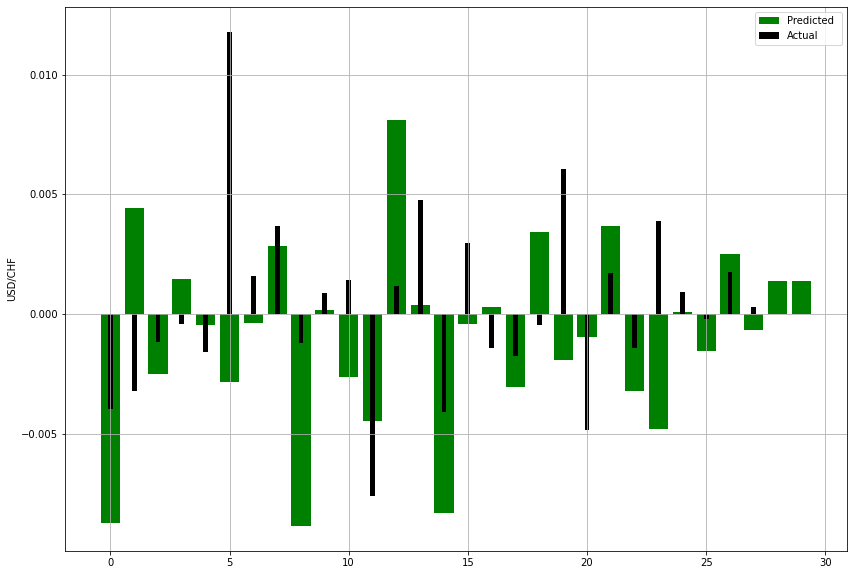

In [310]:
ds.plot_result_ret(outputs, targets, nb=30)


# Gru

In [329]:
gru_model = ml.GRU_base(hidden_size=8,
        num_layers=1,
        input_size=5,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.0)
gru_model

GRU_base(
  (gru): GRU(5, 8, batch_first=True)
  (fc0_bn): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=13, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [330]:
#[:,:,0].reshape(-1,5,1)
train_loss, val_loss = pl.train(gru_model, train_x[:,:,0].reshape(-1,5,1), train_y, val_x[:,:,0].reshape(-1,5,1), val_y, batch_size_= 1024, num_epochs_=1000, lr=0.01, device_='cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 1

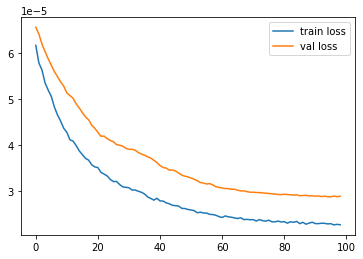

In [323]:
plt.plot(pl.smooth_loss(train_loss, chunksize=10) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize=10) , label="val loss")
plt.legend()
plt.show()

MSE: 0.0022618270492443006%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     66.69
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           8.40e-16
Time:                        14:40:29   Log-Likelihood:                 4476.8
No. Observations:                1136   AIC:                            -8950.
Df Residuals:                    1134   BIC:                            -8940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.684e-05   

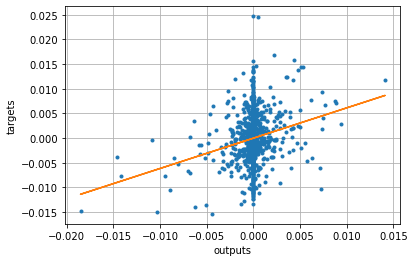

In [324]:
outputs, targets, MSE = pl.evaluate(gru_model, train_x, train_y) 
pl.regression_result(targets, outputs)

accuracy  55.11 %


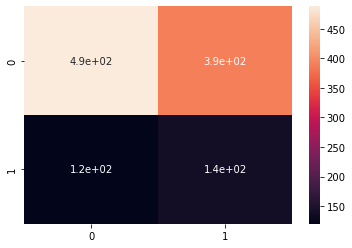

In [325]:
pl.direction_score(outputs, targets)

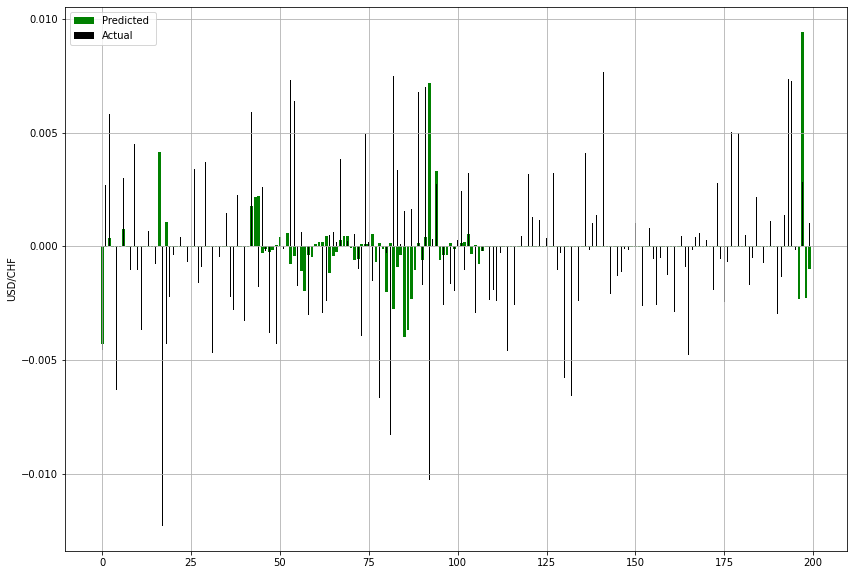

In [328]:
ds.plot_result_ret(outputs, targets, nb=200)